### Initialize notebook

In [1]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report

# Other imports
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('/home/ak/Spring2018/ature')
os.chdir('/home/ak/Spring2018/ature')

from neuralnet.utils.torch_dataset import TorchPatchesGenerator
from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.torchtrainer import NNTrainer
import neuralnet.utils.measurements as mnt
import neuralnet.utils.data_utils as nndutils

%load_ext autoreload
%autoreload 2

/home/ak/Spring2018/ature_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [43]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 64
num_classes = len(classes)
epochs = 10
patch_size = 31
use_gpu = False

#### Images to train/validate per epoch ####
train_size = 20000
validation_size = 5000
checkpoint_file = 'PytorchCheckpoint.nn.tar'

### Define the network

In [44]:
class Net(nn.Module):
    def __init__(self, width, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = width
    
        self.kern_size = 5
        self.kern_stride = 2      
        self.kern_padding = 2
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool1 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv1 = nn.Conv2d(self.channels, 24, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool2 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv2 = nn.Conv2d(24, 52, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 5
        self.kern_stride = 1      
        self.kern_padding = 2
        self.mxp_kern_size = 2
        self.mxp_stride = 2 
        self.pool3 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv3 = nn.Conv2d(52, 96, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.mxp_kern_size = 1
        self.mxp_stride = 1 
        self.pool4 = nn.MaxPool2d(kernel_size=self.mxp_kern_size, stride=self.mxp_stride)
        self.conv4 = nn.Conv2d(96, 30, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self._update_output_size()
        
        self.linearWidth = 30*int(self.width)*int(self.width)
        self.fc1 = nn.Linear(self.linearWidth, 512)
        self.fc2 = nn.Linear(512, 16)
        self.fc3 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.dropout(x, training=self.training, p=0.2)
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.dropout(x, training=self.training, p=0.3)
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, self.linearWidth)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    def _update_output_size(self):       
        temp = self.width
        self.width = ((self.width - self.kern_size + 2 * self.kern_padding) / self.kern_stride) + 1
        temp1 = self.width
        self.width = ((self.width - self.mxp_kern_size)/self.mxp_stride) + 1
        print('Output width[ ' + str(temp) + ' -conv-> ' + str(temp1) + ' -maxpool-> ' + str(self.width) + ' ]')

width = 31
channels = 1
net = Net(width, channels)
optimizer = optim.Adam(net.parameters(), lr=0.00001)

Output width[ 31 -conv-> 16.0 -maxpool-> 16.0 ]
Output width[ 16.0 -conv-> 16.0 -maxpool-> 16.0 ]
Output width[ 16.0 -conv-> 16.0 -maxpool-> 8.0 ]
Output width[ 8.0 -conv-> 8.0 -maxpool-> 8.0 ]


### Load train data

In [45]:
transform = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(40),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ])

trainset = TorchPatchesGenerator(Dirs=Dirs, patch_size=patch_size, 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file) 

### Fix skewed classes by sampling based on class weights
labels = np.array(trainset.IDs)[:,3]
_, ccounts_train = np.unique(labels, return_counts=True)
cweights_train = 1.0/ccounts_train
dweights_train = np.array([cweights_train[t] for t in labels])

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=3, 
                                          sampler=WeightedRandomSampler(dweights_train, train_size))

### 4388140 patches found.


### Load Validation Data

In [46]:
transform_val = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

validation_set = TorchPatchesGenerator(Dirs=ValidationDirs, patch_size=patch_size, 
                                       transform=transform_val,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file) 

labels_val = np.array(validation_set.IDs)[:,3]
_, ccounts_val = np.unique(labels_val, return_counts=True)
cweights_val = 1.0/ccounts_val
dweights_val = np.array([cweights_val[t] for t in labels_val])

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=3,
                                            sampler=WeightedRandomSampler(dweights_val, 
                                                                          validation_size, replacement=True))

### 658074 patches found.


### Train and evaluate the Network

In [48]:
trainer = NNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file)
# trainer.resume_from_checkpoint()
trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=epochs, use_gpu=use_gpu, 
              validationloader=validationloader)
# trainer.resume_from_checkpoint()

Training...
Epoch:[1/10] Batches:[200/313]   Loss: 0.693 Accuracy: 0.422
Epoch:[1/10] Batches:[313/313]   Loss: 0.695 Accuracy: 0.438
Evaluating...
_________ACCURACY___of___[79/79]batches: 50.12%
Accuracy improved from  0.0 to 50.12. Saving model..
Epoch:[2/10] Batches:[200/313]   Loss: 0.691 Accuracy: 0.641
Epoch:[2/10] Batches:[313/313]   Loss: 0.676 Accuracy: 0.594
Evaluating...
_________ACCURACY___of___[79/79]batches: 66.82%
Accuracy improved from  50.12 to 66.82. Saving model..
Epoch:[3/10] Batches:[200/313]   Loss: 0.600 Accuracy: 0.703
Epoch:[3/10] Batches:[313/313]   Loss: 0.380 Accuracy: 0.906
Evaluating...
_________ACCURACY___of___[79/79]batches: 73.84%
Accuracy improved from  66.82 to 73.84. Saving model..
Epoch:[4/10] Batches:[200/313]   Loss: 0.492 Accuracy: 0.750
Epoch:[4/10] Batches:[313/313]   Loss: 0.394 Accuracy: 0.812
Evaluating...
_________ACCURACY___of___[79/79]batches: 80.26%
Accuracy improved from  73.84 to 80.26. Saving model..
Epoch:[5/10] Batches:[200/313]   L

### Test on a image

In [59]:
transform_test = transforms.Compose([
        imgutil.whiten_image2d,
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = TorchPatchesGenerator(Dirs=TestDirs, patch_size=patch_size, 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                segment_mode=True) 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 5000, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, 
                                          shuffle=False, num_workers=3, sampler=None)

### 219737 patches found.


In [ ]:
IDs, IJs, scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...


### Convolve throughout the image to generate segmented image based on trained Network

In [57]:
seg = np.zeros_like(testset.images[0].working_arr)
for val in zip(IDs, IJs, sc):
    image_id, (i, j), (_, prob) = val
    seg[i, j] = 255 * prob

In [ ]:
# IMG.fromarray(seg).save(checkpoint_file+'SEG.png')
print(classification_report(y_true=y_true, y_pred=y_pred))

In [ ]:
mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=['background', 'vessel'])

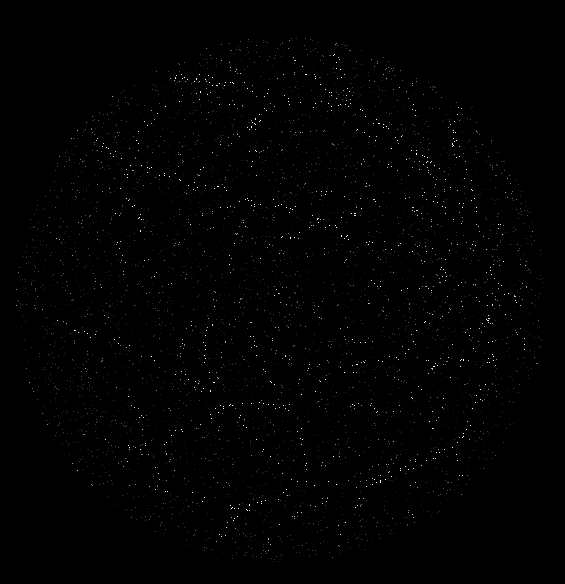

In [58]:
IMG.fromarray(seg)

In [54]:
sc = scores.copy()

In [55]:
sc = np.exp(sc)

In [56]:
sc

array([[0.9172229 , 0.08277712],
       [0.01282686, 0.98717315],
       [0.71323399, 0.28676602],
       ...,
       [0.01490733, 0.98509267],
       [0.89485133, 0.10514868],
       [0.71210343, 0.28789656]])